# Продажа квартир в Санкт-Петербурге: анализ рынка недвижимости

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [123]:
import pandas as pd

In [124]:
estate_data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(estate_data.info())
estate_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

Всего в датафрейме 23699 строк и 22 столбца.
Пропуски:

- ceiling_height. Высота потолков не указана. Заполнять будем по медиане, сначала по каждому населённому пункту, затем оставшиеся - по общей медиане.
- floors_total. Не указано, сколько этажей в доме. Таких немного, и мы не можем восстановить этажность на основе других данных. Оставим как есть.
- living_area. Не указана жилплощадь. Заполняем по медиане в зависимости от города и количества комнат.
- is_apartment. В большинстве строк пропуски. Логично предположить, что в пустых значениях должен быть признак False.
- kitchen_area. Не указана площадь кухни. Посмотрим, какие это квартиры (если студии, то оставляем 0).
- balcony. Не указано количество балконов. Логично предположить, что их нет, т.е. 0.
- locality_name. Не указано название населённого пункта. Оставим, т.к. восстановить не можем.
- airports_nearest. Не указано расстояние до ближайшего аэропорта. Если эту мерику считает Яндекс, лучше уточнить у коллег насчёт пропусков. Поскольку аэропорты есть только в крупных городах, считать расстояние через медиану для всех населённых пунктов не вполне корректно. Оставляем как есть.
- cityCenters_nearest. Не указано расстояние до центра города. Заполнение по медиане может повлиять на полученную статистику и выводы, поэтому вставляем 0.
- parks_around3000. Не указано число парков в радиусе 3 км. Предположим, что их нет и заполним пропуски нулями.
- parks_nearest. Расстояние до ближайшего парка не указано, и таких большинство записей. Возможно, это означает, что расстояние до ближайшего парка слишком велико. Оставим как есть.
- ponds_around3000. Число водоёмов в радиусе трёх километров. Предположим, что их нет и заполним пропуски нулями.
- ponds_nearest. Расстояние до ближайшего водоёма. Пропусков большинство. Предположим, что расстояние слишком велико и оставим пропуски как есть.
- days_exposition. Не указано число дней размещения объявления. Предположим, что объявление было снято в тот же день, что и опубликовано и подставим 0.

### Шаг 2. Предобработка данных

Сначала разберёмся с пропусками. Начнем с высоты потолков, которую заполняем по медиане для каждого населённого пункта. Медиана применима, т.к. максимальная разница между медианой и средним составляет 1.6 метра.

In [125]:
avg_ceiling_height = estate_data.pivot_table(index='locality_name', values = 'ceiling_height', aggfunc=['median', 'mean'])
avg_ceiling_height.columns=['median', 'average']
avg_ceiling_height['difference'] = avg_ceiling_height['median'] - avg_ceiling_height['average']
#print(avg_ceiling_height['difference'].min())
#print(avg_ceiling_height['difference'].max())

locations_list = estate_data['locality_name'].drop_duplicates()
for location in locations_list:
    median_height = estate_data.loc[(estate_data['locality_name'] == location) & 
            (estate_data['ceiling_height'] >0)].sort_values(by=['ceiling_height'])['ceiling_height'].median()
    estate_data.loc[estate_data['locality_name'] == location, 'ceiling_height'] = estate_data.loc[
                    estate_data['locality_name'] == location, 'ceiling_height'].fillna(median_height)

Оставшиеся пустые значения заполняем по общей медиане.

In [126]:
median_height_total = estate_data.loc[
        estate_data['ceiling_height'] > 0].sort_values(by='ceiling_height')['ceiling_height'].median()
estate_data['ceiling_height'] = estate_data['ceiling_height'].fillna(median_height_total)
#estate_data.info()

Переходим к жилплощади. В городах типовая застройка, логично предположить, что средняя площадь жилья зависит от города и количества комнат.

In [127]:
print(estate_data['rooms'].min())
print(estate_data['rooms'].max())
for location in locations_list:
    for i in range(0, 20):
        median_area = estate_data.loc[(estate_data['locality_name'] == location) & 
                            (estate_data['rooms'] == i) &
                            (estate_data['living_area'] > 0)].sort_values(by=['living_area'])['living_area'].median()
        estate_data.loc[(estate_data['locality_name'] == location) & 
                        (estate_data['rooms'] == i), 'living_area'] = estate_data.loc[
                        (estate_data['locality_name'] == location) & (estate_data['rooms'] == i), 'living_area'].fillna(median_area)

0
19


Осталось 60 строк, где неизвестна площадь жилья. В этих строках много других пропусков, поэтому можно удалить их.

In [128]:
estate_data[estate_data['living_area'].isnull()]
estate_data['living_area'].dropna()

0        51.00
1        18.60
2        34.30
3        45.76
4        32.00
         ...  
23694    73.30
23695    38.00
23696    29.70
23697    31.00
23698    12.30
Name: living_area, Length: 23639, dtype: float64

Заполняем признак is_apartment.

In [129]:
estate_data['is_apartment'] = estate_data['is_apartment'].fillna(False)
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23613 non-null float64
living_area             23639 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around3000

Переходим к площади кухни.

In [130]:
estate_data.loc[estate_data['kitchen_area'].isnull()].groupby('studio')['studio'].count()

studio
False    2129
True      149
Name: studio, dtype: int64

2129 студий и 149 обычных квартир. В студиях нет отдельной кухни, поэтому где studio = True, оставляем 0. Для остальных крватир мы не можем рассчитать площадь кухни, поэтому оставляем как есть.

In [131]:
estate_data.loc[estate_data['studio'] == True, 'kitchen_area'] = estate_data.loc[
                estate_data['studio'] == False, 'kitchen_area'].fillna(0)
#estate_data.info()

Заполняем остальные пропуски.

In [132]:
#заполняем пропуски по балконам
estate_data['balcony'] = estate_data['balcony'].fillna(0)
#estate_data.info()

#заполняем пропуски в cityCenters_nearest, parks_around3000, ponds_around3000 и days_exposition
estate_data['cityCenters_nearest'] = estate_data['cityCenters_nearest'].fillna(0)
estate_data['parks_around3000'] = estate_data['parks_around3000'].fillna(0)
estate_data['ponds_around3000'] = estate_data['ponds_around3000'].fillna(0)
estate_data['days_exposition'] = estate_data['days_exposition'].fillna(0)
#estate_data.info()

Преобразуем типы данных. total_area - приводим к типу int, т.к. площадь обычно округляется до квадратного метра. То же самое делаем для living_area.

- first_day_exposition - преобразуем в формат даты с округлением до дня (отбрасываем время, т.к. для нас оно неважно)
- floors_total - к типу int (не может быть 1,5 этажа в доме)
- balcony - к типу int64 (полтора балкона тоже не может быть)
- days_exposition - тоже к типу int (будем мерять в целых днях)

In [133]:
estate_data['total_area'] = estate_data['total_area'].astype('int')
try:
    estate_data['living_area'] = estate_data['living_area'].astype('int')
except:
    pass
estate_data['first_day_exposition'] = pd.to_datetime(estate_data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S').dt.round('D')
try:
    estate_data['floors_total'] = estate_data['floors_total'].astype('int')
except:
    pass
estate_data['balcony'] = estate_data['balcony'].astype('int')
estate_data['days_exposition'] = estate_data['days_exposition'].astype('int')
estate_data['last_price'] = estate_data['last_price'].astype('int')
estate_data.info()
estate_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null int64
total_area              23699 non-null int64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23613 non-null float64
living_area             23639 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null int64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     23699 non-null float64
parks_around3000        23699 non-null float64
parks_nearest           8079 non-null float64
ponds_around30

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108,2019-03-07,3,2.70,16.0,51.00,8,False,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0
1,7,3350000,40,2018-12-04,1,2.63,11.0,18.60,1,False,...,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81
2,10,5196000,56,2015-08-20,2,2.70,5.0,34.30,4,False,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558
3,0,64900000,159,2015-07-24,3,2.70,14.0,45.76,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424
4,2,10000000,100,2018-06-19,2,3.03,14.0,32.00,13,False,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121


### Шаг 3. Посчитайте и добавьте в таблицу

In [134]:
#считаем стоимость квадратного метра
try:
    estate_data['price_per_m2'] = (estate_data['last_price'] / estate_data['living_area']).round(2)
except:
    estate_data['price_per_m2'] = 0
    
#день недели публикации
estate_data['exposition_weekday'] = estate_data['first_day_exposition'].dt.dayofweek
#месяц публикации
estate_data['exposition_month'] = pd.DatetimeIndex(estate_data['first_day_exposition']).month
#год публикации
estate_data['exposition_year'] = estate_data['first_day_exposition'].dt.to_period('Y')
#соотношение жилой и общей площади
try:
    estate_data['living_vs_total_area'] = estate_data['living_area'] / ['total_area']
except:
    estate_data['living_vs_total_area'] = 0
#отношение площади кухни к общей
try:
    estate_data['kitchen_vs_total_area'] = estate_data['kitchen_area'] / estate_data['total_area']
except:
    estate_data['kitchen_vs_total_area'] = 0
    
estate_data['exposition_year'] = estate_data['exposition_year'].astype('int')
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 28 columns):
total_images             23699 non-null int64
last_price               23699 non-null int64
total_area               23699 non-null int64
first_day_exposition     23699 non-null datetime64[ns]
rooms                    23699 non-null int64
ceiling_height           23699 non-null float64
floors_total             23613 non-null float64
living_area              23639 non-null float64
floor                    23699 non-null int64
is_apartment             23699 non-null bool
studio                   23699 non-null bool
open_plan                23699 non-null bool
kitchen_area             21421 non-null float64
balcony                  23699 non-null int64
locality_name            23650 non-null object
airports_nearest         18157 non-null float64
cityCenters_nearest      23699 non-null float64
parks_around3000         23699 non-null float64
parks_nearest            8079 non-null flo

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

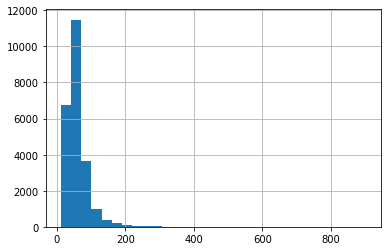

In [135]:
estate_data['total_area'].hist(bins=30)

Большая часть квартир имеет площадь от 30 до 70 квадратных метров. Далее идёт спад, и жильё общей площадью более 100 квадратных метров практически не встречается. Согласно гистограмме, максимальная площадь - 300 квадратов. Жилья с большей площадью либо нет, либо это единичные экземпляры.

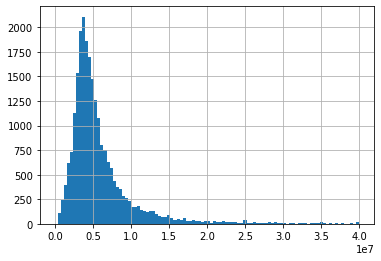

In [136]:
estate_data['last_price'].hist(bins=100, range=(0, 40000000))

Наибольший пик приходится на 4 миллиона рублей. Далее идёт снижение. Жильё стоимостью более 40 миллионов практически не встречается.

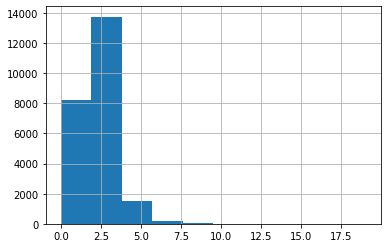

In [137]:
estate_data['rooms'].hist()

Больше всего жилья с 2 и 3 комнатами. Жильё, имеющее больше 6 комнат - редкость.

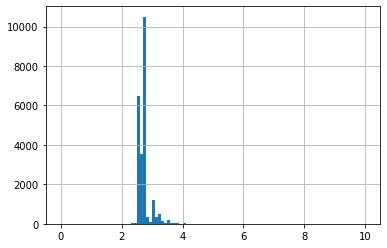

In [138]:
estate_data['ceiling_height'].hist(bins=100, range=(0, 10))

В большинстве случаев высота потолка колеблется в районе 2,5-3 метров. Согласно гистограмме, максимум - 4 метра.

count    23699.000000
mean       156.608844
std        213.546873
min          0.000000
25%         22.000000
50%         74.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

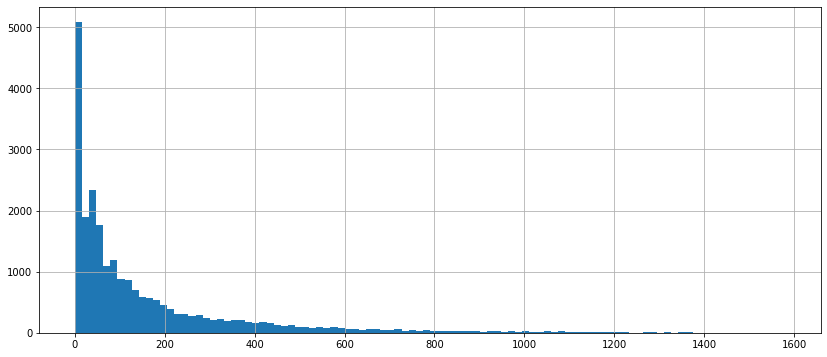

In [139]:
estate_data['days_exposition'].hist(bins=100, figsize=(14, 6))
estate_data['days_exposition'].describe()

1) Согласно гистограмме, чаще всего объявления о продаже висят около 5 дней. Второй пик приходится на 50 дней. При этом среднее время продажи (параметр mean) равно 157 дням, а медиана (параметр 50%) - 74 дням. Это говорит о том, что достаточно много квартир с большим сроком продажи.

2) Квартиль 75% имеет значение в 199 дней. То есть 75% квартир, выставленных на продажу, продаются быстрее, чем за 200 дней. При этом на гистограмме видно, что более 800 дней недвижимость практически не продаётся.

Исходя из вышеописанного, можно вывести следующее: быстрой продажей считается продажа квартиры в течение 5 дней. Необычно долгой можно считать продажу более 800 дней.

Далее отсекаем выброс на 5 днях и значения более 800 дней:

count    19437.000000
mean       159.776715
std        165.352861
min          6.000000
25%         45.000000
50%         95.000000
75%        217.000000
max        800.000000
Name: days_exposition, dtype: float64

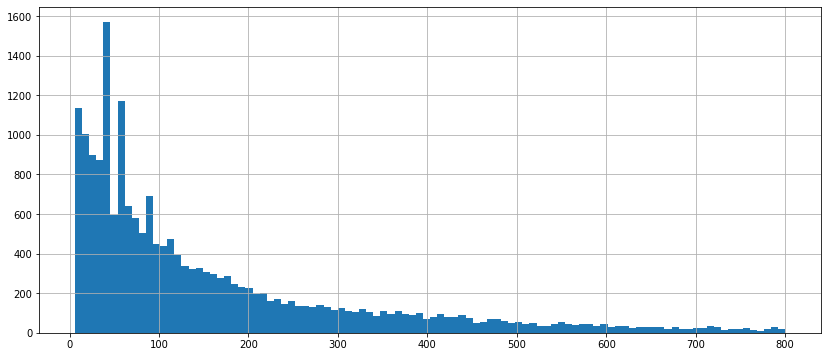

In [140]:
estate_data_regular = estate_data[(estate_data['days_exposition'] > 5) & (estate_data['days_exposition'] <= 800)]
estate_data_regular['days_exposition'].hist(bins=100, figsize=(14, 6))
estate_data_regular['days_exposition'].describe()

Стали более заметны выбросы в районе 40, 60 дней и менее выраженный в 90 дней. Среднее значение практически не изменилось (159 против 156 дней).
Медиана выросла с 74 до 95 дней. В целом можно сказать, что выборка стала более сбалансированной.

<b>Вывод:</b> если квартира не продаётся в первые 5 дней после публикации, она с наибольшей вероятностью продастся за 40 или 60 дней (т.е. в среднем за 1,5-2 месяца). Далее количество проданных квартир уменьшается с учеличением срока продажи.

In [141]:
<div style="border:solid  green  2px; padding: 20px"> <h1 style="color: green ; margin-bottom:20px">Комментарий наставника</h1>

Верно#считаем коэффициенты корреляции Пирсона
print('Корреляция цены от площади:', estate_data['last_price'].corr(estate_data['total_area']))
print('Корреляция цены от количества комнат:', estate_data['last_price'].corr(estate_data['rooms']))
print('Корреляция цены от расстояния до центра:', estate_data['last_price'].corr(estate_data['cityCenters_nearest']))
print('Корреляция цены от дня недели размещения:', estate_data['last_price'].corr(estate_data['exposition_weekday']))
print('Корреляция цены от месяца размещения:', estate_data['last_price'].corr(estate_data['exposition_month']))
print('Корреляция цены от года размещения:', estate_data['last_price'].corr(estate_data['exposition_year']))

Корреляция цены от площади: 0.6536539818654253
Корреляция цены от количества комнат: 0.36334284996489546
Корреляция цены от расстояния до центра: -0.05096092866080519
Корреляция цены от дня недели размещения: 0.0015501452176215431
Корреляция цены от месяца размещения: 0.0027791287507397252
Корреляция цены от года размещения: -0.043089036199508476


На основе расчётов корреляции можно сказать, что есть слабая зависимость цены от площади и ещё меньшая - от количества комнат. При этом цена практически никак не связана с расстоянием до центра, днём недели, месяцем или годом размещения объявления. Скорее всего, влияние оказывают другие параметры, например, город (в Санкт-Петербурге зависимость цены от расположения явно выше, чем в Выборге).

Далее отбираем топ-10 населённых пунктов по количеству объявлений и считаем стоимость квадратного метра:

In [142]:
estate_data_top10 = estate_data.pivot_table(index='locality_name', values='total_images', aggfunc='count').sort_values(
    by='total_images', ascending=False).head(10)

estate_data_top10['avg_m2_price'] = estate_data.pivot_table(
    index='locality_name', values='price_per_m2', aggfunc='mean').round(decimals=2)

estate_data_top10.columns=['total', 'avg_price_m2']
estate_data_top10.sort_values(by='avg_price_m2', ascending=False)

,total,avg_price_m2
locality_name,,
Санкт-Петербург,15721,219132.99
посёлок Парголово,327,200034.15
Пушкин,369,192158.26
деревня Кудрово,299,187925.41
посёлок Мурино,522,176086.09
посёлок Шушары,440,155276.90
Всеволожск,398,133704.57
Колпино,338,132516.89
Гатчина,307,121895.82


<b>Вывод:</b> самый дешёвый город - Выборг, а самые дорогие квартиры - в Санкт-Петербурге.

Посмотрим на срез по Питеру подробнее. Переведём расстояние до центра в километры, рассчитаем среднюю стоимость по каждому километру и построим график зависимости цены от расстояния.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15721 entries, 0 to 23697
Data columns (total 30 columns):
total_images                  15721 non-null int64
last_price                    15721 non-null int64
total_area                    15721 non-null int64
first_day_exposition          15721 non-null datetime64[ns]
rooms                         15721 non-null int64
ceiling_height                15721 non-null float64
floors_total                  15651 non-null float64
living_area                   15721 non-null float64
floor                         15721 non-null int64
is_apartment                  15721 non-null bool
studio                        15721 non-null bool
open_plan                     15721 non-null bool
kitchen_area                  14342 non-null float64
balcony                       15721 non-null int64
locality_name                 15721 non-null object
airports_nearest              15636 non-null float64
cityCenters_nearest           15721 non-null float64
parks

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


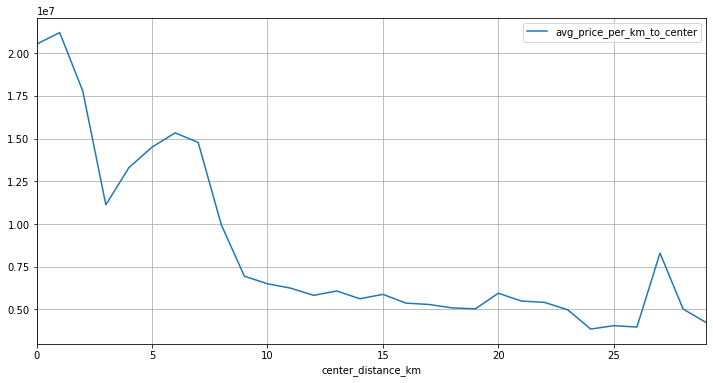

In [143]:
estate_data_spb = estate_data.loc[estate_data['locality_name'] == 'Санкт-Петербург']

estate_data_spb['center_distance_km'] = (estate_data_spb['cityCenters_nearest'] / 1000).round(decimals=0)

#print(estate_data_spb['center_distance_km'].max())
for i in range(0, 30):
    avg_price_per_km = estate_data_spb.loc[estate_data_spb['center_distance_km'] == i]['last_price'].mean()
    estate_data_spb.loc[estate_data_spb['center_distance_km'] == i, 'avg_price_per_km_to_center'] = avg_price_per_km
    
estate_data_spb.info()
(estate_data_spb
    .pivot_table(index='center_distance_km', values='avg_price_per_km_to_center', aggfunc='mean')
    .plot(grid=True, figsize=(12, 6))
)

<b>Вывод:</b> недвижимость ближе 10 километров от центра резко начинает расти в цене.

Сделаем аналитику по недвижимости в центре и сравним параметры с остальным городом:

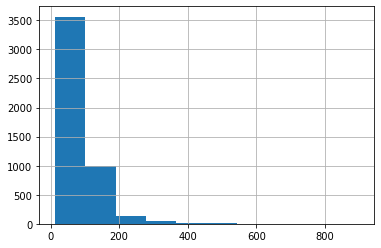

In [144]:
estate_data_spb_center = estate_data_spb.loc[estate_data_spb['center_distance_km'] < 10]
estate_data_spb_center['total_area'].hist()

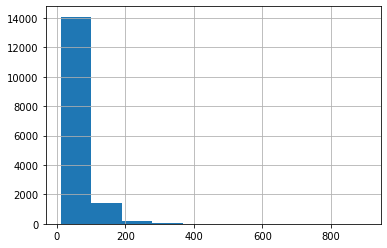

In [145]:
#строим гистограмму для всего города
estate_data_spb['total_area'].hist()

<b>Вывод:</b> в центре выше доля квартир с большой площадью (от 100 квадратов).

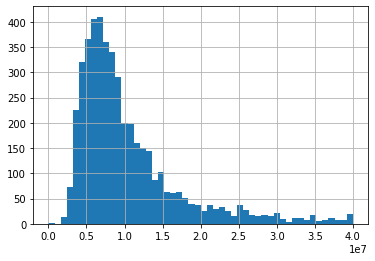

In [146]:
#цена по центру
estate_data_spb_center['last_price'].hist(bins=50, range=(0, 40000000))

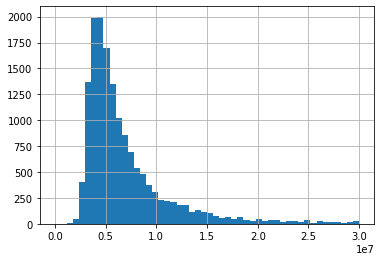

In [147]:
#цена по всему городу
estate_data_spb['last_price'].hist(bins=50, range=(0, 30000000))

<b>Вывод:</b> в центре недвижимость дороже. Больше всего квартир по цене 6-7 миллионов рублей, далее с ростом цены количество продающейся недвижимости снижается. В целом по городу пик приходится на 4 миллиона рублей за квартиру.

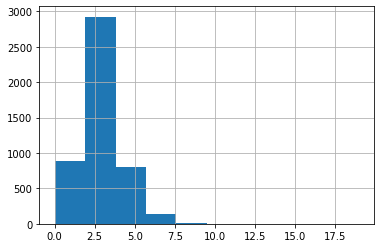

In [148]:
#число комнат по центру
estate_data_spb_center['rooms'].hist()

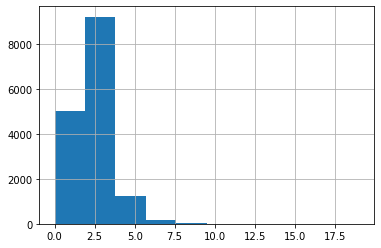

In [149]:
#число комнат по городу
estate_data_spb['rooms'].hist()

<b>Вывод:</b> по количеству комнат картина очень похожая. Однако в центре города значительно ниже доля жилья с 1 комнатой и квартир-студий (0 комнат). Что логично, т.к. такое жильё в основном строят в новых районах на окраине города.

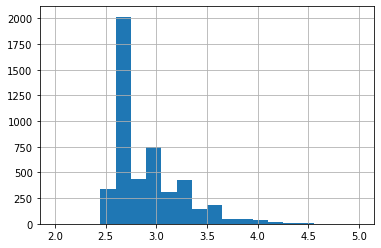

In [150]:
#высота потолков в центре
estate_data_spb_center['ceiling_height'].hist(bins=20, range=(2, 5))

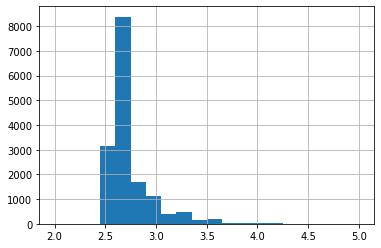

In [151]:
#высота потолков в городе
estate_data_spb['ceiling_height'].hist(bins=20, range=(2, 5))

<b>Вывод:</b> в целом картина в центре города совпадает с тем, что мы видим в целом по Питеру. Примечательно, что в центре квартир с потолком 3 метра существенно больше, чем с потолком 2.80. Потолков более 4 метров практически не встречается. Самая популярная высота - 2.6 метра.

Теперь посчитаем корреляцию цены в целом по городу (т.к. ранее мы считали по всему изначальному датафрейму) и для центра города. Корреляцию будем смотреть со следующими параметрами:

- число комнат
- этаж
- удалённость от центра
- дата размещения объявления

При выводе указан формат до 4 знаков после запятой, чтобы избежать ошибок при выводе (когда число записывается в виде 1е8)

In [152]:
print('Корреляция для всего города:')
print('Цена - число комнат: {:.4f}'.format(estate_data_spb['last_price'].corr(estate_data_spb['rooms'])))
print('Цена - этаж: {:.4f}'.format(estate_data_spb['last_price'].corr(estate_data_spb['floor'])))
print('Цена - удалённость от центра: {:.4f}'.format(estate_data_spb[
    'last_price'].corr(estate_data_spb['center_distance_km'])))
print('Цена - день недели размещения объявления: {:.4f}'.format(estate_data_spb[
    'last_price'].corr(estate_data_spb['exposition_weekday'])))
print('Цена - месяц размещения объявления: {:.4f}'.format(estate_data_spb[
    'last_price'].corr(estate_data_spb['exposition_month'])))
print('Цена - год размещения объявления: {:.4f}'.format(estate_data_spb[
    'last_price'].corr(estate_data_spb['exposition_year'])))
print()
print('Корреляция для центра города:')
print('Цена - число комнат: {:.4f}'.format(estate_data_spb_center[
    'last_price'].corr(estate_data_spb_center['rooms'])))
print('Цена - этаж: {:.4f}'.format(estate_data_spb_center['last_price'].corr(estate_data_spb_center['floor'])))
print('Цена - удалённость от центра: {:.4f}'.format(estate_data_spb_center[
    'last_price'].corr(estate_data_spb_center['center_distance_km'])))
print('Цена - день недели размещения объявления: {:.4f}'.format(estate_data_spb_center[
    'last_price'].corr(estate_data_spb_center['exposition_weekday'])))
print('Цена - месяц размещения объявления: {:.4f}'.format(estate_data_spb_center[
    'last_price'].corr(estate_data_spb_center['exposition_month'])))
print('Цена - год размещения объявления: {:.4f}'.format(estate_data_spb_center[
    'last_price'].corr(estate_data_spb_center['exposition_year'])))

Корреляция для всего города:
Цена - число комнат: 0.3724
Цена - этаж: -0.0008
Цена - удалённость от центра: -0.2606
Цена - день недели размещения объявления: 0.0062
Цена - месяц размещения объявления: 0.0000
Цена - год размещения объявления: -0.0446

Корреляция для центра города:
Цена - число комнат: 0.3525
Цена - этаж: 0.0857
Цена - удалённость от центра: -0.1221
Цена - день недели размещения объявления: 0.0176
Цена - месяц размещения объявления: 0.0041
Цена - год размещения объявления: -0.0535


<b>Вывод:</b> есть слабо выраженная положительная корреляция между ценой и числом комнат, причём для центра города эта корреляция выражена слабее. Также наблюдается слабая обратная зависимость цены от расстояния до центра города, если мы берём срез по городу. В самом центре эта зависимость выражена не так сильно. Действительно, ранее на графике присутствует просадка в цене при расстоянии до центра менее 5 км. Это позволяет сделать вывод, что на цену помимо расстояния влияют другие параметры и некорректно оценивать параметры по отдельности.

### Шаг 5. Общий вывод

1. Полученные данные неполные. Возможно, отсутствие каких-то данных (например, является ли недвижимость апартаменатми), появляется вследсдвие недоработки онлайн-формы. Другие (например, расстояние до центра), возможно, некорректно считаются алогритмом сайата. В любом случае, собранную информацию необходимо передать коллегам для анализа и исправления возможных ошибок.
2. Большая часть квартир имеет площадь от 30 до 70 квадратных метров. Жильё общей площадью более 100 квадратных метров практически не встречается. Максимальная площадь - 300 квадратов. Жилья с большей площадью либо нет, либо это единичные экземпляры.
3. Больше всего квартир продаётся по цене около 4 миллионов рублей.Жильё стоимостью более 40 миллионов практически не встречается.
4. Больше всего жилья с 2 и 3 комнатами. Жильё, имеющее больше 6 комнат - редкость.
5. В большинстве случаев высота потолка колеблется в районе 2,5-3 метров.
6. Большинство объявлений о продаже висят около 5 дней. Вряд ли действительно продажа происходит так быстро, возможно, это снятие и публикакция одного и того же объявления с целью поднять объявление в выдаче либо иные манипуляции. Это нужно отследить. Если квартира не продаётся в первые 5 дней после публикации, она с наибольшей вероятностью продастся за 40 или 60 дней (т.е. в среднем за 1,5-2 месяца). 75% квартир, выставленных на продажу, продаются быстрее, чем за 200 дней. Исходя из этих данных, можно сказать, что быстрой продажей считается продажа квартиры в течение 5 дней. Необычно долгой можно считать продажу более 800 дней.
7. Самый дешёвый город - Выборг, а самые дорогие квартиры - в Санкт-Петербурге.
8. В Санкт-Петербурге недвижимость ближе 10 километров от центра резко начинает расти в цене.
9. В центре Петербурга выше доля квартир с большой площадью (от 100 квадратных метров).
10. В центре Питера недвижимость дороже. Больше всего квартир по цене 6-7 миллионов рублей, далее с ростом цены количество продающейся недвижимости снижается. В целом по городу пик приходится на 4 миллиона рублей за квартиру.
11. В центре Петербурга значительно ниже доля жилья с 1 комнатой и квартир-студий (0 комнат). Что логично, т.к. такое жильё в основном строят в новых районах на окраине города.
12. В центре города квартир с потолком 3 метра существенно больше, чем с потолком 2.80. Потолков более 4 метров практически не встречается. Самая популярная высота - 2.6 метра.